# ReAct Agent 만들기
- ReAct(Reasoning + Acting)는 대화형 AI가 복잡한 문제를 해결할 때 사용하는 프롬프팅 기법입니다.

## ReAct Agent란?

**ReAct = Reasoning + Acting**
- **Reasoning (추론)**: 문제를 분석하고 다음 단계를 계획
- **Acting (행동)**: 실제로 도구를 사용하여 정보 수집이나 작업 수행
- **Observation (관찰)**: 행동의 결과를 확인하고 다음 추론에 활용

이 과정을 반복하여 최종 답안에 도달합니다.

In [1]:
# 필요한 라이브러리 설치 및 import
import os
from dotenv import load_dotenv
from langchain import hub
from langchain.agents import create_react_agent, AgentExecutor
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langchain_community.tools import TavilySearchResults
import json

# 환경 변수 로드
load_dotenv()

# API 키 설정 확인
if not os.getenv("OPENAI_API_KEY"):
    print("OPENAI_API_KEY를 .env 파일에 설정해주세요.")

if not os.getenv("TAVILY_API_KEY"):
    print("TAVILY_API_KEY를 .env 파일에 설정해주세요. (웹 검색용)")

print("라이브러리 임포트 완료!")


라이브러리 임포트 완료!


## 1. 기본 ReAct Agent 설정

먼저 기본적인 수학 계산 도구를 만들어 ReAct 패턴을 이해해보겠습니다.


### 커스텀 도구 정의

In [2]:
@tool
def calculator(expression: str) -> str:
    """
    수학 계산을 수행합니다.
    expression: 계산할 수학 표현식 (예: "2 + 3 * 4")
    """
    try:
        # 안전한 계산을 위해 eval 대신 간단한 계산만 허용
        allowed_chars = set('0123456789+-*/.() ')
        if not all(c in allowed_chars for c in expression):
            return "오류: 허용되지 않는 문자가 포함되어 있습니다."

        result = eval(expression)
        return f"계산 결과: {expression} = {result}"
    except Exception as e:
        return f"계산 오류: {str(e)}"

@tool
def get_length(text: str) -> str:
    """
    텍스트의 길이를 반환합니다.
    text: 길이를 측정할 텍스트
    """
    return f"텍스트 '{text}'의 길이: {len(text)}글자"

# 도구 리스트 생성
tools = [calculator, get_length]

print("커스텀 도구 생성 완료!")
print("사용 가능한 도구:")
for tool in tools:
    print(f"- {tool.name}: {tool.description}")


커스텀 도구 생성 완료!
사용 가능한 도구:
- calculator: 수학 계산을 수행합니다.
expression: 계산할 수학 표현식 (예: "2 + 3 * 4")
- get_length: 텍스트의 길이를 반환합니다.
text: 길이를 측정할 텍스트


### ReAct Agent 생성

In [3]:
# LangChain Hub에서 ReAct 프롬프트 가져오기
react_prompt = hub.pull("hwchase17/react")

# LLM 초기화
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    api_key=os.getenv("OPENAI_API_KEY")
)

# ReAct Agent 생성
agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=react_prompt
)

# Agent Executor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,  # 추론 과정을 자세히 출력
    handle_parsing_errors=True,
    max_iterations=5
)

print("ReAct Agent 설정 완료!")


ReAct Agent 설정 완료!


### 기본 ReAct 예시 실행

In [4]:
print("=" * 60)
print("예시 1: 기본 수학 계산과 텍스트 분석")
print("=" * 60)

question1 = "25 * 4 + 10을 계산하고, 그 결과를 문자열로 변환했을 때의 길이를 알려주세요."

try:
    result1 = agent_executor.invoke({"input": question1})
    print(f"\n최종 답변: {result1['output']}")
except Exception as e:
    print(f"오류 발생: {str(e)}")


예시 1: 기본 수학 계산과 텍스트 분석


> Entering new AgentExecutor chain...
우선 수학 계산을 하고, 그 결과를 문자열로 변환한 후에 길이를 측정해야 합니다.
Action: calculator
Action Input: "25 * 4 + 10"계산 결과: 25 * 4 + 10 = 110이제 계산 결과를 문자열로 변환하고, 그 길이를 측정해야 합니다.
Action: get_length
Action Input: "110"텍스트 '110'의 길이: 3글자계산 결과인 '110'의 길이는 3글자입니다.
Final Answer: 3

> Finished chain.

최종 답변: 3


## 2. 웹 검색 도구를 활용한 실제 사용 예시

실시간 정보 검색이 필요한 복잡한 질문을 ReAct Agent로 해결해보겠습니다.


### 웹 검색 도구 추가

In [5]:
search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    api_key=os.getenv("TAVILY_API_KEY")
)

# 웹 검색이 포함된 도구 리스트
web_tools = [calculator, get_length, search_tool]

/var/folders/tv/05qbcb8954z9x1yvqv_kr2t80000gn/T/ipykernel_81746/206651437.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(


### 웹 검색 Agent 생성

In [6]:
web_agent = create_react_agent(
    llm=llm,
    tools=web_tools,
    prompt=react_prompt
)

web_agent_executor = AgentExecutor(
    agent=web_agent,
    tools=web_tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=10  # 웹 검색을 위해 더 많은 반복 허용
)

print("웹 검색 기능이 포함된 ReAct Agent 설정 완료!")


웹 검색 기능이 포함된 ReAct Agent 설정 완료!


### 웹 검색을 활용한 복잡한 질문 해결

In [7]:
print("=" * 60)
print("예시 2: 웹 검색을 활용한 실시간 정보 분석")
print("=" * 60)

question2 = """
오늘 비트코인 가격을 검색하고, 그 가격을 10으로 나눈 후,
결과값을 문자열로 변환했을 때의 길이를 알려주세요.
"""

try:
    result2 = web_agent_executor.invoke({"input": question2})
    print(f"\n최종 답변: {result2['output']}")
except Exception as e:
    print(f"오류 발생: {str(e)}")
    print("참고: TAVILY_API_KEY가 설정되어 있는지 확인해주세요.")


예시 2: 웹 검색을 활용한 실시간 정보 분석


> Entering new AgentExecutor chain...
비트코인 가격을 검색하고, 그 값을 10으로 나누어 문자열로 변환한 후 길이를 측정해야 합니다.

Action: tavily_search_results_json
Action Input: "current bitcoin price"[{'title': 'Bitcoin price today, BTC to USD live ...', 'url': 'https://coinmarketcap.com/currencies/bitcoin/', 'content': 'The live Bitcoin price today is $113,985 USD with a 24-hour trading volume of $66,653,065,646 USD. We update our BTC to USD price in real-time. Bitcoin is up 0.43% in the last 24 hours. The current CoinMarketCap ranking is #1, with a live market cap of $2,269,364,317,070 USD. It has a circulating supply of 19,909,343 BTC coins and a max. supply of 21,000,000 BTC coins. [...] Thanks to its pioneering nature, BTC remains at the top of this energetic market after over a decade of existence. Even after Bitcoin has lost its undisputed dominance, it remains the largest cryptocurrency, with a market capitalization that surpassed the $1 trillion mark in 2021, after Bitcoin price hit 

## 3. 고급 예시: 커스텀 도구를 활용한 복합 작업

더 복잡한 도구들을 추가하여 실제 업무에서 활용할 수 있는 ReAct Agent를 만들어보겠습니다.


### 고급 커스텀 도구들 정의

In [8]:
import datetime
import random
from langchain.tools import tool

@tool
def get_current_time() -> str:
    """현재 날짜와 시간을 반환합니다."""
    now = datetime.datetime.now()
    return f"현재 시간: {now.strftime('%Y년 %m월 %d일 %H시 %M분 %S초')}"

@tool
def generate_random_number(min_val: int, max_val: int) -> str:
    """
    지정된 범위에서 무작위 숫자를 생성합니다.
    min_val: 최소값
    max_val: 최대값
    """
    if min_val > max_val:
        return "오류: 최소값이 최대값보다 클 수 없습니다."

    random_num = random.randint(min_val, max_val)
    return f"{min_val}과 {max_val} 사이의 무작위 숫자: {random_num}"

@tool
def analyze_text(text: str) -> str:
    """
    텍스트를 분석하여 다양한 정보를 제공합니다.
    text: 분석할 텍스트
    """
    word_count = len(text.split())
    char_count = len(text)
    char_count_no_spaces = len(text.replace(' ', ''))

    analysis = f"""
        텍스트 분석 결과:
        - 전체 글자 수: {char_count}
        - 공백 제외 글자 수: {char_count_no_spaces}
        - 단어 수: {word_count}
        - 평균 단어 길이: {char_count_no_spaces/word_count if word_count > 0 else 0:.2f}
    """
    return analysis

@tool
def save_to_memory(key: str, value: str) -> str:
    """
    키-값 쌍을 메모리에 저장합니다.
    key: 저장할 키
    value: 저장할 값
    """
    if not hasattr(save_to_memory, 'memory'):
        save_to_memory.memory = {}

    save_to_memory.memory[key] = value
    return f"'{key}': '{value}' 저장 완료"

@tool
def get_from_memory(key: str) -> str:
    """
    메모리에서 값을 조회합니다.
    key: 조회할 키
    """
    if not hasattr(save_to_memory, 'memory'):
        return "메모리가 비어있습니다."

    if key in save_to_memory.memory:
        return f"'{key}': '{save_to_memory.memory[key]}'"
    else:
        return f"'{key}' 키를 찾을 수 없습니다."

# 고급 도구 리스트
advanced_tools = [
    calculator,
    get_length,
    search_tool,
    get_current_time,
    generate_random_number,
    analyze_text,
    save_to_memory,
    get_from_memory
]

print("고급 커스텀 도구들 생성 완료!")
print("\n사용 가능한 고급 도구들:")
for tool in advanced_tools:
    print(f"- {tool.name}: {tool.description}")


고급 커스텀 도구들 생성 완료!

사용 가능한 고급 도구들:
- calculator: 수학 계산을 수행합니다.
expression: 계산할 수학 표현식 (예: "2 + 3 * 4")
- get_length: 텍스트의 길이를 반환합니다.
text: 길이를 측정할 텍스트
- tavily_search_results_json: A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.
- get_current_time: 현재 날짜와 시간을 반환합니다.
- generate_random_number: 지정된 범위에서 무작위 숫자를 생성합니다.
min_val: 최소값
max_val: 최대값
- analyze_text: 텍스트를 분석하여 다양한 정보를 제공합니다.
text: 분석할 텍스트
- save_to_memory: 키-값 쌍을 메모리에 저장합니다.
key: 저장할 키
value: 저장할 값
- get_from_memory: 메모리에서 값을 조회합니다.
key: 조회할 키


### 고급 ReAct Agent 생성

In [9]:
advanced_agent = create_react_agent(
    llm=llm,
    tools=advanced_tools,
    prompt=react_prompt
)

advanced_agent_executor = AgentExecutor(
    agent=advanced_agent,
    tools=advanced_tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=15  # 복잡한 작업을 위해 더 많은 반복 허용
)

print("고급 ReAct Agent 설정 완료!")


고급 ReAct Agent 설정 완료!


### 복합적인 작업 수행

In [10]:
print("=" * 60)
print("예시 3: 복합적인 작업 시나리오")
print("=" * 60)

complex_question = """
다음 작업들을 순서대로 수행해주세요:

1. 현재 시간을 확인하고 'current_time'이라는 키로 메모리에 저장하세요.
2. 1부터 100 사이의 무작위 숫자를 생성하세요.
3. 그 숫자를 5로 나눈 결과를 계산하세요.
4. "ReAct Agent는 정말 똑똑합니다!"라는 텍스트를 분석하세요.
5. 메모리에서 저장된 시간을 다시 조회하세요.
6. 모든 결과를 종합하여 요약해주세요.
"""

try:
    result3 = advanced_agent_executor.invoke({"input": complex_question})
    print(f"\n최종 답변: {result3['output']}")
except Exception as e:
    print(f"오류 발생: {str(e)}")


예시 3: 복합적인 작업 시나리오


> Entering new AgentExecutor chain...
각 단계를 차례로 수행하고 결과를 메모리에 저장하고 나중에 모든 결과를 종합해야 합니다.

Action: get_current_time
Action Input: None현재 시간: 2025년 08월 21일 17시 12분 59초현재 시간을 확인했습니다. 이제 메모리에 저장해야 합니다.

Action: save_to_memory
Action Input: key: 'current_time', value: '2025년 08월 21일 17시 12분 59초'오류 발생: 1 validation error for save_to_memory
value
  Field required [type=missing, input_value={'key': "key: 'current_ti...일 17시 12분 59초'"}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing


## 4. ReAct 패턴 분석 및 시각화

ReAct Agent의 추론 과정을 더 자세히 분석해보겠습니다.


### ReAct 패턴을 단계별로 보여주는 함수

In [11]:
def demonstrate_react_pattern():
    """ReAct 패턴의 각 단계를 설명하는 함수"""

    print("ReAct 패턴의 구조:")
    print("\n1. Thought (생각): 문제를 분석하고 다음 단계를 계획")
    print("2. Action (행동): 도구를 사용하여 정보를 수집하거나 작업을 수행")
    print("3. Observation (관찰): 행동의 결과를 확인")
    print("4. 반복: 목표에 도달할 때까지 1-3 단계를 반복")
    print("\n" + "="*50)

    # 간단한 예시로 패턴 시연
    question = "15 * 3의 결과가 짝수인지 홀수인지 알려주세요."

    print(f"질문: {question}")
    print("\nReAct 과정 시뮬레이션:")

    print("\nThought: 15 * 3을 계산하고, 그 결과가 짝수인지 홀수인지 판단해야 합니다.")
    print("Action: calculator 도구를 사용하여 15 * 3을 계산합니다.")

    # 실제 계산
    result = 15 * 3
    print(f"Observation: 계산 결과는 {result}입니다.")

    print(f"Thought: {result}이 짝수인지 홀수인지 판단해야 합니다.")
    print("Action: 수학적 규칙을 적용합니다 (숫자를 2로 나눈 나머지가 0이면 짝수)")

    is_even = result % 2 == 0
    print(f"Observation: {result} ÷ 2의 나머지는 {result % 2}입니다.")

    print(f"Thought: 나머지가 {result % 2}이므로, {result}는 {'짝수' if is_even else '홀수'}입니다.")
    print(f"Final Answer: {result}는 {'짝수' if is_even else '홀수'}입니다.")

# 패턴 시연 실행
demonstrate_react_pattern()


ReAct 패턴의 구조:

1. Thought (생각): 문제를 분석하고 다음 단계를 계획
2. Action (행동): 도구를 사용하여 정보를 수집하거나 작업을 수행
3. Observation (관찰): 행동의 결과를 확인
4. 반복: 목표에 도달할 때까지 1-3 단계를 반복

질문: 15 * 3의 결과가 짝수인지 홀수인지 알려주세요.

ReAct 과정 시뮬레이션:

Thought: 15 * 3을 계산하고, 그 결과가 짝수인지 홀수인지 판단해야 합니다.
Action: calculator 도구를 사용하여 15 * 3을 계산합니다.
Observation: 계산 결과는 45입니다.
Thought: 45이 짝수인지 홀수인지 판단해야 합니다.
Action: 수학적 규칙을 적용합니다 (숫자를 2로 나눈 나머지가 0이면 짝수)
Observation: 45 ÷ 2의 나머지는 1입니다.
Thought: 나머지가 1이므로, 45는 홀수입니다.
Final Answer: 45는 홀수입니다.


### 실제 Agent와 비교해보기

In [12]:
print("\n" + "="*60)
print("실제 Agent로 같은 문제 해결하기")
print("="*60)

comparison_question = "15 * 3의 결과가 짝수인지 홀수인지 알려주세요."

try:
    comparison_result = agent_executor.invoke({"input": comparison_question})
    print(f"\nAgent의 답변: {comparison_result['output']}")
except Exception as e:
    print(f"오류 발생: {str(e)}")



실제 Agent로 같은 문제 해결하기


> Entering new AgentExecutor chain...
We need to calculate the result of 15 * 3 and determine if it is even or odd.
Action: calculator
Action Input: "15 * 3"계산 결과: 15 * 3 = 45Now we need to check if 45 is even or odd.
Action: calculator
Action Input: "45 % 2"오류: 허용되지 않는 문자가 포함되어 있습니다.We can't use the modulo operator directly with the calculator function. Let's try a different approach.
Action: calculator
Action Input: "45 / 2"계산 결과: 45 / 2 = 22.5Since 22.5 is not a whole number, we know that 45 is an odd number.
Final Answer: 홀수 (Odd)

> Finished chain.

Agent의 답변: 홀수 (Odd)


## 5. ReAct Agent 활용 팁과 모범 사례


### ReAct Agent 활용 팁

1. **명확한 질문 작성**: 구체적이고 명확한 질문을 작성하면 더 정확한 결과를 얻을 수 있습니다.

2. **도구 선택**: 문제 해결에 필요한 적절한 도구들을 선택하는 것이 중요합니다.

3. **반복 횟수 조절**: `max_iterations`를 적절히 설정하여 무한 루프를 방지하면서도 충분한 추론 시간을 확보합니다.

4. **오류 처리**: `handle_parsing_errors=True`로 설정하여 파싱 오류에 대한 복원력을 높입니다.

### 도구 설계 원칙

1. **단일 책임**: 각 도구는 하나의 명확한 기능을 수행해야 합니다.
2. **명확한 문서화**: 도구의 목적과 사용법을 명확히 문서화합니다.
3. **오류 처리**: 예상 가능한 오류 상황에 대한 적절한 처리를 포함합니다.
4. **타입 힌트**: 입력 매개변수의 타입을 명확히 지정합니다.

### 실제 활용 사례

- **데이터 분석**: 웹 검색 + 계산 + 텍스트 분석
- **콘텐츠 생성**: 검색 + 요약 + 저장
- **업무 자동화**: 스케줄링 + 알림 + 데이터 처리
- **학습 보조**: 질문 + 검색 + 설명 생성

# LangGraph를 활용한 ReAct Agent 만들기

이 노트북에서는 [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/#define-graph-state)를 참고하여 처음부터 ReAct Agent를 만드는 방법을 학습합니다.

## 1. 환경 설정 및 필수 라이브러리 설치

먼저 LangGraph와 관련 라이브러리들을 설치하고 환경을 설정합니다.


In [13]:
# 필요한 라이브러리 import
import os
import json
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv

# LangChain 관련 라이브러리
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

# LangGraph 라이브러리
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# 환경 변수 로드
load_dotenv()

# API 키 확인
if not os.getenv("OPENAI_API_KEY"):
    print("OPENAI_API_KEY를 .env 파일에 설정해주세요.")
else:
    print("OPENAI_API_KEY 설정 확인!")

print("모든 라이브러리 임포트 완료!")


OPENAI_API_KEY 설정 확인!
모든 라이브러리 임포트 완료!


## 2. 그래프 상태 정의하기

LangGraph에서는 에이전트의 상태를 정의해야 합니다. 상태는 그래프 실행 중에 노드들 간에 공유되는 데이터입니다.

### 상태(State)란?
- 에이전트가 실행되는 동안 **메모리 역할**을 하는 데이터 구조
- 각 노드에서 **읽고 쓸 수 있는** 공통 저장소
- **메시지 기록, 계산 결과, 중간 상태** 등을 저장


In [14]:
# 에이전트 상태 정의
class AgentState(TypedDict):
    """
    ReAct 에이전트의 상태를 정의합니다.

    Attributes:
        messages: 대화 메시지들의 시퀀스
                 add_messages는 새로운 메시지를 기존 리스트에 추가하는 리듀서 함수입니다.
    """
    # add_messages는 리듀서(reducer) 함수입니다
    # 이는 새로운 메시지들을 기존 메시지 리스트에 자동으로 추가해줍니다
    messages: Annotated[Sequence[BaseMessage], add_messages]

print("AgentState 클래스 정의 완료!")
print("\n상태 구조:")
print("- messages: 사용자와 AI 간의 대화 기록을 저장")
print("- add_messages: 새 메시지를 자동으로 리스트에 추가하는 기능")

# 리듀서(Reducer) 설명
print("\nadd_messages 리듀서의 역할:")
print("1. 기존 메시지 리스트 유지")
print("2. 새로운 메시지들을 끝에 추가")
print("3. 중복 메시지 자동 제거")
print("4. 메시지 순서 보장")


AgentState 클래스 정의 완료!

상태 구조:
- messages: 사용자와 AI 간의 대화 기록을 저장
- add_messages: 새 메시지를 자동으로 리스트에 추가하는 기능

add_messages 리듀서의 역할:
1. 기존 메시지 리스트 유지
2. 새로운 메시지들을 끝에 추가
3. 중복 메시지 자동 제거
4. 메시지 순서 보장


## 3. 모델과 도구 정의하기

이제 ReAct Agent가 사용할 AI 모델과 도구들을 정의합니다.

### 모델이란?
- GPT, Claude 등 **언어 모델**
- 추론과 응답 생성을 담당

### 도구(Tools)란?
- Agent가 **외부 정보에 접근**하거나 **특정 작업을 수행**할 수 있게 해주는 함수
- 예: 날씨 조회, 계산기, 웹 검색, 데이터베이스 조회 등


In [15]:
# AI 모델 설정
model = ChatOpenAI(
    model="gpt-4o-mini",  # 비용 효율적인 모델 사용
    temperature=0,         # 일관된 응답을 위해 temperature를 0으로 설정
    api_key=os.getenv("OPENAI_API_KEY")
)

print("AI 모델 설정 완료!")
print(f"사용 모델: {model.model_name}")
print(f"Temperature: {model.temperature} (더 일관된 응답)")


AI 모델 설정 완료!
사용 모델: gpt-4o-mini
Temperature: 0.0 (더 일관된 응답)


In [16]:
# 학습용 도구들 정의
@tool
def get_weather(location: str) -> str:
    """
    특정 지역의 날씨 정보를 조회합니다.

    Args:
        location: 날씨를 조회할 지역명

    Returns:
        해당 지역의 날씨 정보
    """
    # 실제로는 날씨 API를 호출하지만, 학습용으로 가상의 데이터를 반환합니다
    location_lower = location.lower()

    if any(city in location_lower for city in ["seoul", "서울"]):
        return "서울의 날씨: 맑음, 기온 20°C, 습도 60%"
    elif any(city in location_lower for city in ["busan", "부산"]):
        return "부산의 날씨: 흐림, 기온 18°C, 습도 75%"
    elif any(city in location_lower for city in ["sf", "san francisco", "샌프란시스코"]):
        return "샌프란시스코의 날씨: 해가 나고 있지만 쌍둥이자리라면 조심하세요!"
    else:
        return f"{location}의 날씨 정보를 찾을 수 없습니다. 죄송합니다."

@tool
def calculator(expression: str) -> str:
    """
    수학 계산을 수행합니다.

    Args:
        expression: 계산할 수학 표현식 (예: "2 + 3 * 4")

    Returns:
        계산 결과
    """
    try:
        # 보안을 위해 허용된 문자만 사용
        allowed_chars = set('0123456789+-*/.() ')
        if not all(c in allowed_chars for c in expression):
            return "오류: 허용되지 않는 문자가 포함되어 있습니다."

        result = eval(expression)
        return f"계산 결과: {expression} = {result}"
    except Exception as e:
        return f"계산 오류: {str(e)}"

@tool
def get_current_time() -> str:
    """
    현재 시간을 조회합니다.

    Returns:
        현재 날짜와 시간
    """
    import datetime
    now = datetime.datetime.now()
    return f"현재 시간: {now.strftime('%Y년 %m월 %d일 %H시 %M분')}"

# 도구 리스트 생성
tools = [get_weather, calculator, get_current_time]

# 모델에 도구 바인딩 (모델이 도구를 사용할 수 있도록 연결)
model = model.bind_tools(tools)

print("도구 정의 및 바인딩 완료!")
print("\n사용 가능한 도구들:")
for tool in tools:
    print(f"- {tool.name}: {tool.description}")

print(f"\n총 {len(tools)}개의 도구가 모델에 바인딩되었습니다.")


도구 정의 및 바인딩 완료!

사용 가능한 도구들:
- get_weather: 특정 지역의 날씨 정보를 조회합니다.

Args:
    location: 날씨를 조회할 지역명

Returns:
    해당 지역의 날씨 정보
- calculator: 수학 계산을 수행합니다.

Args:
    expression: 계산할 수학 표현식 (예: "2 + 3 * 4")

Returns:
    계산 결과
- get_current_time: 현재 시간을 조회합니다.

Returns:
    현재 날짜와 시간

총 3개의 도구가 모델에 바인딩되었습니다.


## 4. 노드(Node)와 엣지(Edge) 구현하기

LangGraph에서는 에이전트의 동작을 **노드**와 **엣지**로 표현합니다.

### 노드(Node)란?
- 그래프의 **각 단계**를 나타내는 함수
- 예: `call_model`, `tool_node`, `decision_node` 등
- 상태를 받아서 **처리 후 업데이트된 상태를 반환**

### 엣지(Edge)란?
- 노드와 노드를 **연결하는 경로**
- **조건부 엣지**: 상황에 따라 다른 노드로 이동
- **일반 엣지**: 항상 특정 노드로 이동


In [17]:
# 도구별로 쉽게 찾을 수 있도록 딕셔너리 생성
tools_by_name = {tool.name: tool for tool in tools}

print("도구 딕셔너리 생성:")
for name, tool in tools_by_name.items():
    print(f"  '{name}' -> {tool.description.split('.')[0]}")


도구 딕셔너리 생성:
  'get_weather' -> 특정 지역의 날씨 정보를 조회합니다
  'calculator' -> 수학 계산을 수행합니다
  'get_current_time' -> 현재 시간을 조회합니다


In [ ]:
# 도구 실행 노드 정의
def tool_node(state: AgentState):
    """
    AI가 요청한 도구들을 실행하는 노드입니다.

    Args:
        state: 현재 그래프 상태

    Returns:
        도구 실행 결과가 포함된 업데이트된 상태
    """
    print("도구 노드 실행 중...")

    outputs = []
    # 마지막 메시지에서 도구 호출 정보를 가져옵니다
    last_message = state["messages"][-1]

    # 각 도구 호출에 대해 실행
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]

        print(f"  {tool_name} 도구 호출: {tool_args}")

        # 해당 도구 실행
        tool_result = tools_by_name[tool_name].invoke(tool_args)

        print(f"  결과: {tool_result}")

        # 도구 결과를 ToolMessage로 변환
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_name,
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outputs}

print("도구 노드 정의 완료!")


도구 노드 정의 완료!


In [ ]:
# AI 모델 호출 노드 정의
def call_model(state: AgentState, config: RunnableConfig):
    """
    AI 모델을 호출하여 응답을 생성하는 노드입니다.

    Args:
        state: 현재 그래프 상태
        config: 실행 설정

    Returns:
        AI 응답이 포함된 업데이트된 상태
    """
    print("AI 모델 노드 실행 중...")

    # 시스템 프롬프트 설정
    system_prompt = SystemMessage(
        content="""당신은 도움이 되는 AI 어시스턴트입니다.
        사용자의 질문에 최선을 다해 답변해주세요!

        주어진 도구들을 적절히 활용하여 정확한 정보를 제공하세요.
        - 날씨 정보가 필요하면 get_weather 도구를 사용하세요
        - 계산이 필요하면 calculator 도구를 사용하세요
        - 현재 시간이 필요하면 get_current_time 도구를 사용하세요

        모든 답변은 한국어로 해주세요."""
    )

    # 시스템 프롬프트 + 기존 메시지들을 함께 모델에 전달
    messages = [system_prompt] + state["messages"]

    print(f"  총 {len(messages)}개의 메시지를 모델에 전달")

    # AI 모델 호출
    response = model.invoke(messages, config)

    print(f"  AI 응답 생성 완료 (도구 호출: {len(response.tool_calls) if response.tool_calls else 0}개)")

    # 응답을 리스트로 반환 (기존 메시지 리스트에 추가되도록)
    return {"messages": [response]}

print("AI 모델 노드 정의 완료!")


AI 모델 노드 정의 완료!


In [ ]:
# 조건부 엣지 함수 정의
def should_continue(state: AgentState):
    """
    다음에 어떤 노드로 이동할지 결정하는 조건부 엣지 함수입니다.

    Args:
        state: 현재 그래프 상태

    Returns:
        "continue": 도구를 사용해야 하는 경우
        "end": 응답이 완료된 경우
    """
    messages = state["messages"]
    last_message = messages[-1]

    # 마지막 메시지에 도구 호출이 있는지 확인
    if not last_message.tool_calls:
        print("  도구 호출이 없으므로 대화를 종료합니다")
        return "end"
    else:
        print(f"  {len(last_message.tool_calls)}개의 도구 호출이 있으므로 계속 진행합니다")
        return "continue"

print("조건부 엣지 함수 정의 완료!")
print("\n흐름 제어 로직:")
print("- AI가 도구를 호출하면 → 'continue' → 도구 노드로 이동")
print("- AI가 최종 답변을 하면 → 'end' → 대화 종료")


조건부 엣지 함수 정의 완료!

흐름 제어 로직:
- AI가 도구를 호출하면 → 'continue' → 도구 노드로 이동
- AI가 최종 답변을 하면 → 'end' → 대화 종료


## 5. 그래프 생성 및 컴파일

이제 정의한 노드들과 엣지들을 연결하여 실제 그래프를 만들어봅시다.

### 그래프 구조
```
시작 → [AI 모델] → 도구 호출 있음?
                     ├─ 예 → [도구 실행] → [AI 모델]
                     └─ 아니오 → 종료
```


In [21]:
# 그래프 생성 및 구성
print("ReAct Agent 그래프 생성 중...")

# 1. StateGraph 인스턴스 생성
workflow = StateGraph(AgentState)

# 2. 노드 추가
workflow.add_node("agent", call_model)      # AI 모델 노드
workflow.add_node("tools", tool_node)      # 도구 실행 노드

print("노드 추가 완료:")
print("  - 'agent': AI 모델 호출 노드")
print("  - 'tools': 도구 실행 노드")

# 3. 시작점 설정 (첫 번째로 실행될 노드)
workflow.set_entry_point("agent")
print("시작점 설정: 'agent' 노드부터 시작")

# 4. 조건부 엣지 추가
workflow.add_conditional_edges(
    # 시작 노드: agent 노드 실행 후 조건 확인
    "agent",
    # 조건 함수: should_continue 함수로 다음 노드 결정
    should_continue,
    # 조건에 따른 경로 매핑
    {
        "continue": "tools",  # 도구 호출이 있으면 tools 노드로
        "end": END,          # 도구 호출이 없으면 종료
    },
)
print("조건부 엣지 추가: agent → (조건에 따라) tools 또는 END")

# 5. 일반 엣지 추가
workflow.add_edge("tools", "agent")
print("일반 엣지 추가: tools → agent")

print("\n그래프 구조 완성!")
print("흐름: 시작 → agent → (도구 호출시) tools → agent → ... → 종료")


ReAct Agent 그래프 생성 중...
노드 추가 완료:
  - 'agent': AI 모델 호출 노드
  - 'tools': 도구 실행 노드
시작점 설정: 'agent' 노드부터 시작
조건부 엣지 추가: agent → (조건에 따라) tools 또는 END
일반 엣지 추가: tools → agent

그래프 구조 완성!
흐름: 시작 → agent → (도구 호출시) tools → agent → ... → 종료


In [30]:
# 그래프 컴파일
print("그래프 컴파일 중...")

graph = workflow.compile()

print("ReAct Agent 그래프 컴파일 완료!")
print("이제 에이전트를 사용할 준비가 되었습니다!")


그래프 컴파일 중...
ReAct Agent 그래프 컴파일 완료!
이제 에이전트를 사용할 준비가 되었습니다!


## 6. ReAct Agent 사용해보기

이제 완성된 ReAct Agent를 실제로 사용해봅시다!

### 사용 방법
1. **입력**: 사용자 질문을 메시지 형태로 제공
2. **실행**: `graph.stream()`으로 단계별 실행
3. **출력**: 각 단계별 결과 확인


In [23]:
# 스트림을 예쁘게 출력하는 헬퍼 함수
def print_stream(stream):
    """
    그래프 실행 스트림을 보기 좋게 출력하는 함수
    """
    for step_output in stream:
        # 각 단계의 메시지 출력
        message = step_output["messages"][-1]

        if isinstance(message, tuple):
            print(message)
        else:
            # 메시지 타입에 따라 다르게 출력
            message.pretty_print()

print("스트림 출력 함수 준비 완료!")


스트림 출력 함수 준비 완료!


In [24]:
# 예시 1: 날씨 조회
print("=" * 60)
print("예시 1: 날씨 정보 조회")
print("=" * 60)

# 입력 메시지 설정
inputs = {"messages": [("user", "서울의 날씨가 어떤가요?")]}

print("ReAct Agent 실행 시작!\n")

try:
    # 그래프 실행 (스트림 모드로 단계별 확인)
    stream = graph.stream(inputs, stream_mode="values")
    print_stream(stream)

    print("\n첫 번째 예시 완료!")

except Exception as e:
    print(f"오류 발생: {str(e)}")
    print("API 키가 올바르게 설정되었는지 확인해주세요.")


예시 1: 날씨 정보 조회
ReAct Agent 실행 시작!

================================ Human Message =================================

서울의 날씨가 어떤가요?
AI 모델 노드 실행 중...
  총 2개의 메시지를 모델에 전달
  AI 응답 생성 완료 (도구 호출: 1개)
  1개의 도구 호출이 있으므로 계속 진행합니다
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_RqLqJyEaNKM5f0P1Y52vBdSv)
 Call ID: call_RqLqJyEaNKM5f0P1Y52vBdSv
  Args:
    location: 서울
도구 노드 실행 중...
  get_weather 도구 호출: {'location': '서울'}
  결과: 서울의 날씨: 맑음, 기온 20°C, 습도 60%
================================= Tool Message =================================
Name: get_weather

"\uc11c\uc6b8\uc758 \ub0a0\uc528: \ub9d1\uc74c, \uae30\uc628 20\u00b0C, \uc2b5\ub3c4 60%"
AI 모델 노드 실행 중...
  총 4개의 메시지를 모델에 전달
  AI 응답 생성 완료 (도구 호출: 0개)
  도구 호출이 없으므로 대화를 종료합니다
================================== Ai Message ==================================

서울의 현재 날씨는 흐림이며, 기온은 20도 섭씨입니다. 습도는 60%입니다.

첫 번째 예시 완료!


In [25]:
# 예시 2: 복합 질문 (시간 + 계산)
print("\n" + "=" * 60)
print("예시 2: 복합 질문 - 시간 조회 및 계산")
print("=" * 60)

inputs2 = {
    "messages": [
        ("user", "현재 시간을 알려주고, 25 * 4 + 10을 계산해주세요.")
    ]
}

print("복합 질문 처리 시작!\n")

try:
    stream2 = graph.stream(inputs2, stream_mode="values")
    print_stream(stream2)

    print("\n두 번째 예시 완료!")

except Exception as e:
    print(f"오류 발생: {str(e)}")



예시 2: 복합 질문 - 시간 조회 및 계산
복합 질문 처리 시작!

================================ Human Message =================================

현재 시간을 알려주고, 25 * 4 + 10을 계산해주세요.
AI 모델 노드 실행 중...
  총 2개의 메시지를 모델에 전달
  AI 응답 생성 완료 (도구 호출: 2개)
  2개의 도구 호출이 있으므로 계속 진행합니다
================================== Ai Message ==================================
Tool Calls:
  get_current_time (call_9jAJSBXSeZiMqUESBdssrmhu)
 Call ID: call_9jAJSBXSeZiMqUESBdssrmhu
  Args:
  calculator (call_mSpkxN7qLEDsVtqYrg2hXDwq)
 Call ID: call_mSpkxN7qLEDsVtqYrg2hXDwq
  Args:
    expression: 25 * 4 + 10
도구 노드 실행 중...
  get_current_time 도구 호출: {}
  결과: 현재 시간: 2025년 08월 21일 17시 13분
  calculator 도구 호출: {'expression': '25 * 4 + 10'}
  결과: 계산 결과: 25 * 4 + 10 = 110
================================= Tool Message =================================
Name: calculator

"\uacc4\uc0b0 \uacb0\uacfc: 25 * 4 + 10 = 110"
AI 모델 노드 실행 중...
  총 5개의 메시지를 모델에 전달
  AI 응답 생성 완료 (도구 호출: 0개)
  도구 호출이 없으므로 대화를 종료합니다
================================== Ai Message ===

In [26]:
# 예시 3: 일반 대화 (도구 사용 없음)
print("\n" + "=" * 60)
print("예시 3: 일반 대화 - 도구 없이 답변")
print("=" * 60)

inputs3 = {
    "messages": [
        ("user", "안녕하세요! LangGraph에 대해 간단히 설명해주세요.")
    ]
}

print("일반 대화 처리 시작!\n")

try:
    stream3 = graph.stream(inputs3, stream_mode="values")
    print_stream(stream3)

    print("\n세 번째 예시 완료!")

except Exception as e:
    print(f"오류 발생: {str(e)}")



예시 3: 일반 대화 - 도구 없이 답변
일반 대화 처리 시작!

================================ Human Message =================================

안녕하세요! LangGraph에 대해 간단히 설명해주세요.
AI 모델 노드 실행 중...
  총 2개의 메시지를 모델에 전달
  AI 응답 생성 완료 (도구 호출: 0개)
  도구 호출이 없으므로 대화를 종료합니다
================================== Ai Message ==================================

LangGraph는 자연어 처리(NLP)와 그래프 데이터베이스를 결합한 기술로, 언어 데이터를 그래프 형태로 모델링하여 다양한 언어 관련 작업을 수행할 수 있도록 돕습니다. 이 기술은 언어의 의미와 관계를 시각적으로 표현하고, 이를 통해 정보 검색, 추천 시스템, 지식 그래프 구축 등 다양한 응용 분야에서 활용됩니다.

LangGraph는 언어의 구조와 의미를 더 잘 이해할 수 있게 해주며, 복잡한 언어적 관계를 탐색하고 분석하는 데 유용합니다. 이를 통해 사용자에게 더 나은 정보 제공과 의사결정을 지원할 수 있습니다.

세 번째 예시 완료!


## 7. 그래프 시각화 및 디버깅

LangGraph는 그래프를 시각화하여 에이전트의 동작을 쉽게 이해할 수 있도록 도와줍니다.


```
                    시작
                     |
                     v
         +---------agent---------+
         |           |           |
     continue        ^           |
         |           |           |
         v           |           |
         +---tools---+           v
                                종료
```

그래프 시각화 시도 중...


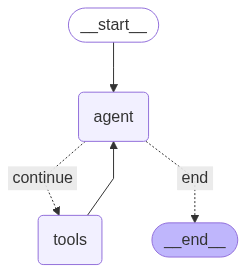

그래프 시각화 성공!


In [27]:
# 그래프 시각화 시도
print("그래프 시각화 시도 중...")

try:
    # IPython 환경에서 이미지 표시를 위한 import
    from IPython.display import Image, display

    # Mermaid 다이어그램으로 그래프 시각화
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("그래프 시각화 성공!")

except Exception as e:
    print(f"그래프 시각화 실패: {str(e)}")
    print("이는 추가 의존성(graphviz, pillow 등)이 필요할 수 있습니다.")
    print("하지만 기능적으로는 정상 작동합니다!")


In [28]:
# 그래프 구조 텍스트로 출력
print("\n그래프 구조 (텍스트 형태):")
print("=" * 40)

try:
    # 그래프의 기본 정보 출력
    graph_info = graph.get_graph()

    print("노드들:")
    for node_id in graph_info.nodes:
        print(f"  - {node_id}")

    print("\n엣지들:")
    for edge in graph_info.edges:
        print(f"  - {edge.source} → {edge.target}")

    print(f"\n시작점: agent")
    print(f"상태 타입: AgentState")

except Exception as e:
    print(f"그래프 정보 출력 중 오류: {e}")

print("\n" + "=" * 40)



그래프 구조 (텍스트 형태):
노드들:
  - __start__
  - agent
  - tools
  - __end__

엣지들:
  - __start__ → agent
  - tools → agent
  - agent → tools
  - agent → __end__

시작점: agent
상태 타입: AgentState

